In [1]:
# Install alpha genome
from IPython.display import clear_output
! pip install alphagenome
clear_output()

In [2]:
from alphagenome import colab_utils
from alphagenome.data import gene_annotation, genome, track_data, transcript
from alphagenome.models import dna_client
from alphagenome.visualization import plot_components
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [ ]:
api_key = 

In [4]:
# Select the DNA_model
dna_model = dna_client.create(api_key)
[output.name for output in dna_client.OutputType]

['ATAC',
 'CAGE',
 'DNASE',
 'RNA_SEQ',
 'CHIP_HISTONE',
 'CHIP_TF',
 'SPLICE_SITES',
 'SPLICE_SITE_USAGE',
 'SPLICE_JUNCTIONS',
 'CONTACT_MAPS',
 'PROCAP']

In [5]:
# Load metadata objects for mouse.
output_metadata = dna_model.output_metadata(
    organism=dna_client.Organism.MUS_MUSCULUS
)

In [6]:
gtf = pd.read_feather(
    "https://storage.googleapis.com/alphagenome/reference/gencode/mm10/gencode.vM23.annotation.gtf.gz.feather"
)

In [7]:
# Filter to protein-coding genes and highly supported transcripts.
gtf_transcript = gene_annotation.filter_transcript_support_level(gtf, ['1'])

# Extractor for identifying transcripts in a region.
transcript_extractor = transcript.TranscriptExtractor(gtf_transcript)

# Also define an extractor that fetches only the longest transcript per gene.
gtf_longest_transcript = gene_annotation.filter_to_longest_transcript(
    gtf_transcript
)
longest_transcript_extractor = transcript.TranscriptExtractor(
    gtf_longest_transcript
)

In [103]:

output_metadata = dna_model.output_metadata(
    dna_client.Organism.MUS_MUSCULUS
).concatenate()


In [ ]:
output_metadata[output_metadata["biosample_name"] == "heart"]

In [8]:
# Set tissue 
ontology_terms = ['UBERON:0000948']  # Heart

In [9]:
# Set genomic interval - converted from mm39 to mm10
interval = genome.Interval('chr5', 148_867_486, 149_183_789).resize(
    dna_client.SEQUENCE_LENGTH_1MB
)
longest_transcripts = longest_transcript_extractor.extract(interval)

In [10]:
# Make predictions.
output = dna_model.predict_interval(
    interval,
    requested_outputs={
        dna_client.OutputType.DNASE,
        dna_client.OutputType.ATAC,
    },
    ontology_terms=ontology_terms,
)

In [70]:
output

Output(atac=TrackData(values=array([], shape=(1048576, 0), dtype=float32), metadata=Empty DataFrame
Columns: [name, strand]
Index: [], resolution=1, interval=Interval(chromosome='chr5', start=148501350, end=149549926, strand='.', name=''), uns=None), cage=None, dnase=TrackData(values=array([[0.01452637],
       [0.01635742],
       [0.0090332 ],
       ...,
       [0.38671875],
       [0.12402344],
       [0.38085938]], dtype=float32), metadata=                       name strand Assay title  ontology_curie biosample_name  \
0  UBERON:0000948 DNase-seq      .   DNase-seq  UBERON:0000948          heart   

  biosample_type biosample_life_stage data_source endedness  \
0         tissue            embryonic      encode    paired   

   genetically_modified  nonzero_mean  
0                 False      0.738096  , resolution=1, interval=Interval(chromosome='chr5', start=148501350, end=149549926, strand='.', name=''), uns=None), rna_seq=None, chip_histone=None, chip_tf=None, splice_sites=None

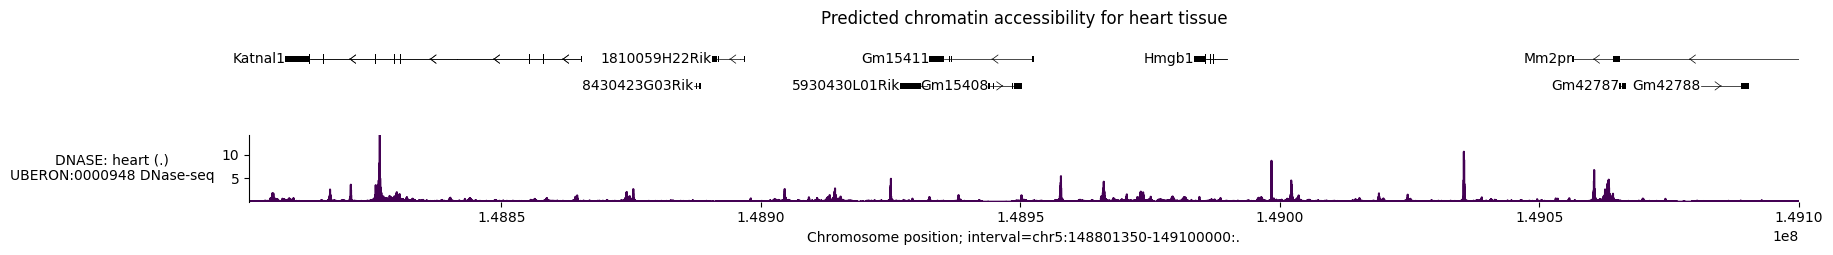

In [11]:
plot = plot_components.plot(
    [
        plot_components.TranscriptAnnotation(longest_transcripts),
        plot_components.Tracks(
            tdata=output.dnase,
            ylabel_template='DNASE: {biosample_name} ({strand})\n{name}',
        ),
        plot_components.Tracks(
            tdata=output.atac,
            ylabel_template='ATAC: {biosample_name} ({strand})\n{name}',
        ),
    ],
    interval=genome.Interval('chr5', 148_801_350, 149_100_000),
    title='Predicted chromatin accessibility for heart tissue',
)

In [13]:
output_metadata.chip_histone[
    output_metadata.chip_histone['biosample_name'].str.contains('heart')
]

# Make predictions.
output = dna_model.predict_interval(
    interval=interval,
    requested_outputs={dna_client.OutputType.CHIP_HISTONE},
    ontology_terms=ontology_terms,
)

In [14]:
reordered_chip_histone = output.chip_histone.select_tracks_by_index(
    output.chip_histone.metadata.sort_values('histone_mark').index
)

histone_to_color = {
    'H3K27AC': '#e41a1c',
    'H3K36ME3': '#ff7f00',
    'H3K4ME1': '#377eb8',
    'H3K4ME3': '#984ea3',
    'H3K9AC': '#4daf4a',
    'H3K27ME3': '#ffc0cb',
}

track_colors = (
    reordered_chip_histone.metadata['histone_mark']
    .map(lambda x: histone_to_color.get(x.upper(), '#000000'))
    .values
)

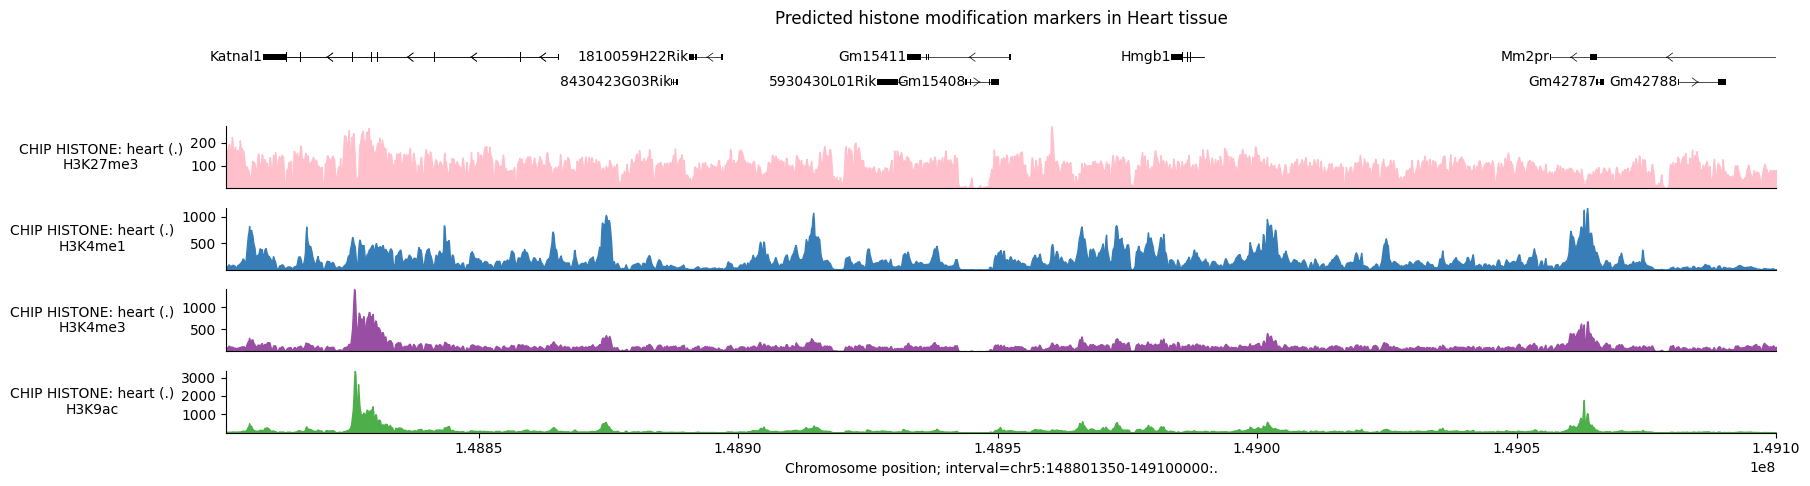

In [21]:
# Build plot.
plot = plot_components.plot(
    [
        plot_components.TranscriptAnnotation(longest_transcripts),
        plot_components.Tracks(
            tdata=reordered_chip_histone,
            ylabel_template=(
                'CHIP HISTONE: {biosample_name} ({strand})\n{histone_mark}'
            ),
            filled=True,
            track_colors=track_colors,
        ),
    ],
    interval=genome.Interval('chr5', 148_801_350, 149_100_000),
    despine_keep_bottom=True,
    title='Predicted histone modification markers in Heart tissue',
)
